In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('bbc_text_cls.csv')

In [6]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [8]:
df['targets'] = df['labels'].astype("category").cat.codes

In [10]:
# number of classes
K = df['targets'].max() + 1
K

5

In [12]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [14]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [16]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27653 unique tokens.


In [18]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1557, 2841)


In [20]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3476)


In [20]:
# Create the model

# We get to choose embedding dimensionality
D = 50

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(64, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [24]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=50,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2563 - loss: 1.5952 - val_accuracy: 0.6587 - val_loss: 1.4737
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7256 - loss: 1.3672 - val_accuracy: 0.7949 - val_loss: 1.0628
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8638 - loss: 0.8726 - val_accuracy: 0.8668 - val_loss: 0.5959
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9216 - loss: 0.4528 - val_accuracy: 0.9057 - val_loss: 0.3917
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9416 - loss: 0.2756 - val_accuracy: 0.9132 - val_loss: 0.3058
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9641 - loss: 0.1802 - val_accuracy: 0.9162 - val_loss: 0.2582
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9799 - loss: 0.1268 - val_accuracy: 0.9251 - val_loss: 0.2287
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9821 - loss: 0.1031 - val_ac

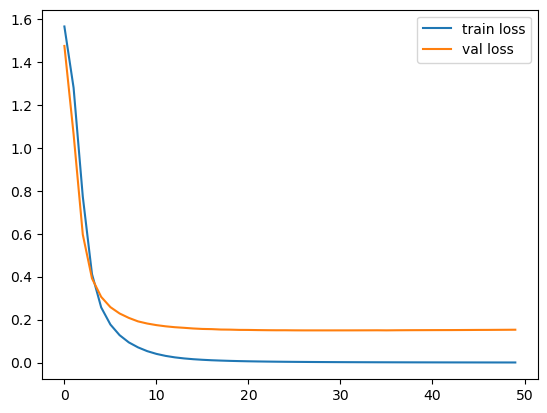

In [25]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

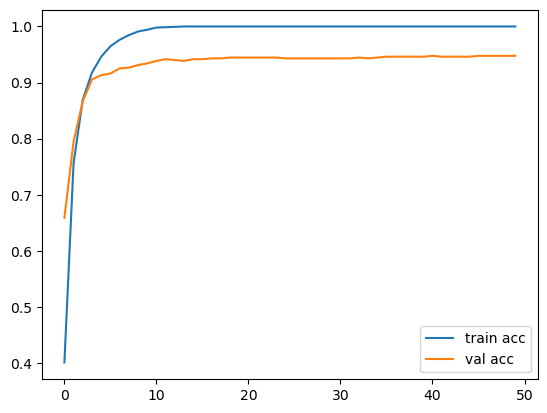

In [26]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();